<a href="https://colab.research.google.com/github/dhcryan/kaggle_challenge_/blob/main/week7/stores_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **상점 신용카드 매출 예측 경진대회**

- **평가 항목**
    *   주어진 데이터 정제
    *   변수 구축 및 선택
    *   모델 선택 및 정규화 과정
    *   최적화 과정



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
train=pd.read_csv('/content/drive/MyDrive/kaggle/credit_prediction/funda_train.csv')

In [3]:
train.shape

(6556613, 9)

In [7]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   store_id          6556613 non-null  int64  
 1   card_id           6556613 non-null  int64  
 2   card_company      6556613 non-null  object 
 3   transacted_date   6556613 non-null  object 
 4   transacted_time   6556613 non-null  object 
 5   installment_term  6556613 non-null  int64  
 6   region            4513847 non-null  object 
 7   type_of_business  2604004 non-null  object 
 8   amount            6556613 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [8]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

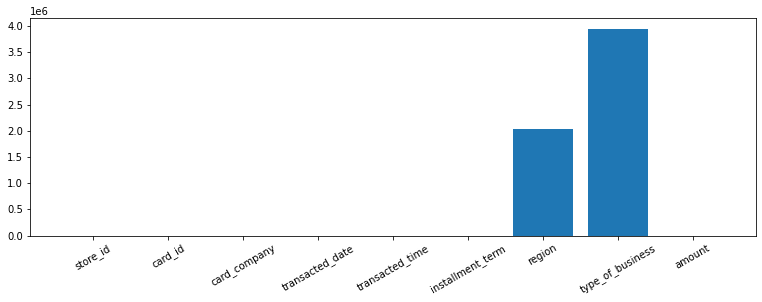

In [12]:
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.figure(figsize=(13,4))
plt.bar(train.columns,train.isnull().sum())
plt.xticks(rotation=30)

In [13]:
train=train.drop(['region','type_of_business'],axis=1)
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


- 매출액 변수에 대한 이상치 확인

<AxesSubplot:xlabel='amount'>

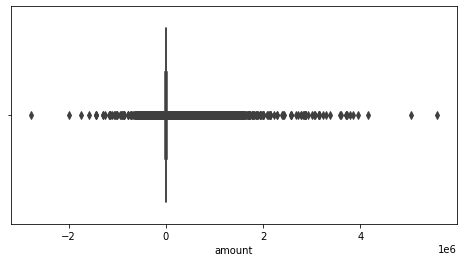

In [14]:
plt.figure(figsize=(8,4))
sns.boxplot(train['amount'])

- 음수 데이터는 아마도 환불 데이터로 추정되기 때문에 없애야 됨


In [23]:
train[train['amount']<0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
41,0,40,a,2016-06-10,17:26,2,-8571.428571,2016-06-10 17:26:00
347,0,285,a,2016-08-04,17:52,0,-1857.142857,2016-08-04 17:52:00
731,0,473,g,2016-10-17,10:32,0,-2000.000000,2016-10-17 10:32:00
831,0,230,b,2016-11-03,15:36,0,-85.714286,2016-11-03 15:36:00
944,0,138,a,2016-11-28,13:21,0,-57.142857,2016-11-28 13:21:00


- 거래일과 거래시간을 합친 변수 생성

In [20]:
train['datetime']=pd.to_datetime(train.transacted_date+" "+train.transacted_time,format="%Y-%m-%d %H:%M:%S")

In [26]:
def remove_refund(df):
    # 환불데이터 추출
    refund=df[df['amount']<0]
    non_refund=df[df['amount']>0] 
    removed_data=pd.DataFrame()
    for i in tqdm(df.store_id.unique()):
        # 한 가게에서의 refund와 non_refund를 구분
        divided_data=non_refund[non_refund['store_id']==i] #
        divided_data2=refund[refund['store_id']==i]
        for neg in divided_data2.to_records()[:]: # 환불데이터를 차례대로 검사한다.
            refund_store=neg['store_id']
            refund_id=neg['card_id']
            refund_datetime=neg['datetime']
            refund_amount=abs(neg['amount'])
            # 환불 시간 이전의 데이터 중 하나식 세면서 카드 아이디와 환불액이 같은 것을 후보리스트로 뽑는다. 
            # 리스트니까 가게 하나당 여러개의 기록들이 있겠죠... 양수데이터에서 차례차례대로 그것들을 검사하는 깅ㅁ
            refund_pay_list=divided_data[divided_data['datetime']<=refund_datetime]
            refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]
            # 후보 리스트가 있으면 카드 아이디, 환불액이 같은 것을 또 뽑는다. 아마도 거의 하나밖에 없겠죠 환불액까지 같기는 쉽지 않으니깐
            # 아무튼 찾았으면 가장 최근 시간의 데이터를 제거한다.
            if len(refund_pay_list)!=0:
                # 환불한건지 이게 환불안한건지 파악하려면 그 특정 데이터 에서 가장 가까운 날짜가 제거 대상이다.
                refund_datetime=max(refund_pay_list['datetime'])
                remove_list=divided_data[divided_data['datetime']==refund_datetime]
                remove_list=remove_list[remove_list['card_id']==refund_id]
                remove_list=remove_list[remove_list['amount']==refund_amount]
        # 환불금액으로 인해 생긴 가상의 매출액을 제거하여(반복) 
                divided_data=divided_data.drop(index=remove_list.index)
        # 가게마다 반복하여 데이터프레임에 추가     
        removed_data=pd.concat([removed_data,divided_data],axis=0)
    return removed_data


100%|██████████| 1967/1967 [09:23<00:00,  3.49it/s]


<AxesSubplot:xlabel='amount'>

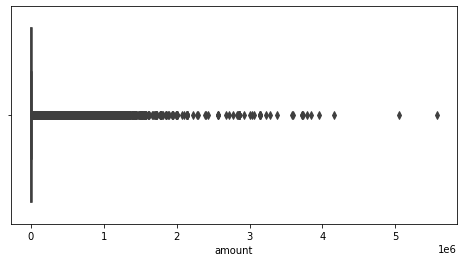

In [27]:
positive_data=remove_refund(train)
plt.figure(figsize=(8,4))
sns.boxplot(positive_data['amount'])

In [30]:
positive_data.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


### **Downsampling**

- 현재 데이터는 분 단위로 기록되어 있으나 예측 구간이 상당히 많음
- 따라서 시간 간격을 재조정해야 함

In [ ]:
# 월 단위 downsampling 함수를 의미한다.
def month_downsampling(df):
    new_data=pd.DataFrame()
    df['year_month']=df['transacted_date'].str.slice(stop=7)
    # 데이터의 전체기간만 따로 추출
    year_month=df['year_month'].drop_duplicates()
    # 상점 아이디별 월 단위 매출액 총합 구하기;
    downsampling_data=df.groupby(['store_id','year_month']).amount().sum()
    downsampling_data=pd.DataFrame(downsampling_data)
    downsampling_data=downsampling_data.reset_index(drop=False,inplace=False)

    for i in 

In [32]:
new_data=pd.DataFrame()
positive_data['year_month']=positive_data['transacted_date'].str.slice(stop=7)
# 데이터의 전체기간만 따로 추출
year_month=positive_data['year_month'].drop_duplicates()
# 상점 아이디별 월 단위 매출액 총합 구하기;
downsampling_data=positive_data.groupby(['store_id','year_month']).amount.sum()
downsampling_data=pd.DataFrame(downsampling_data)
downsampling_data=downsampling_data.reset_index(drop=False,inplace=False)

In [35]:
year_month=pd.DataFrame(year_month)

In [36]:
year_month

,year_month
0,2016-06
145,2016-07
323,2016-08
494,2016-09
654,2016-10
821,2016-11
953,2016-12
1098,2017-01
1216,2017-02
1363,2017-03


In [37]:
downsampling_data

,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
60145,2136,2018-10,2.012214e+06
60146,2136,2018-11,2.127643e+06
60147,2136,2018-12,2.427429e+06
60148,2136,2019-01,1.867786e+06
